In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplt
import descartes
import geopandas as gpd
import numpy as np
import datetime

from shapely.geometry import Point, Polygon
%matplotlib inline

# CS 418 Semester Project, Analysis of Fire Start Data across United States

### Group Members:
* Trevor Parchem (tparch3)
* Sai Nadkarni (snadka2)

### Inspections

To-Do list WIP

Unpreventable fires:-
1. Lightning fires all years
2. Lightning fires over the last decade
3. Deliberate fires as part of prescribed burn

Preventable fires:-
1. Campfires
2. Smoking
3. Juveniles
4. Incendiary

Detailed analyses- Get co-ords of localities with high population, cross check with dataset co-ords to see interlap. Encourage preventative steps in those locations

Ambitious goal- Use linear regression to plot trend for lightning fires(possible to predict nature? unsure). Could look into supplementing dataset with another data of 2014-2019 and compare predictions with actual data.

Clustering- Use k-means to cluster data points i.e fire locations and manually look for the most damaging one in terms of $$$ lost

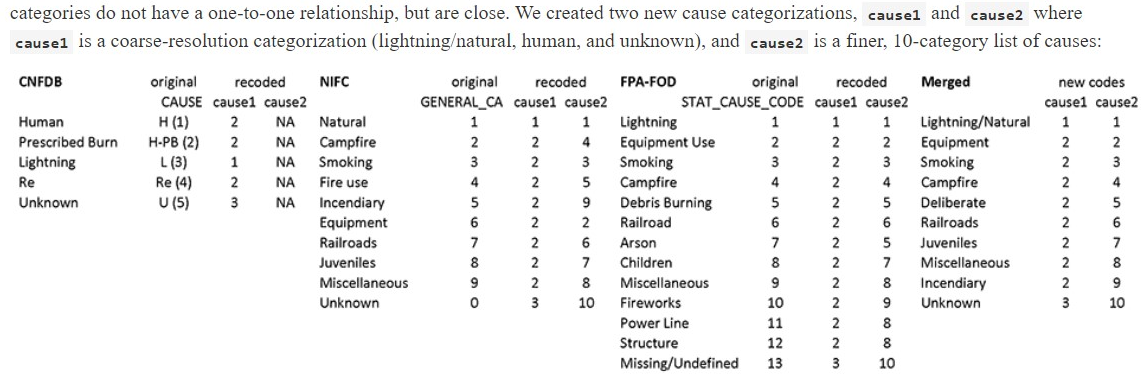

## Loading the Data

In [3]:
# Load the data from the CSV file containing the merged records from United States & Canada Fire Agencies
data = pd.read_csv("uscan_1986-2013.csv")

data.head(10)

,datasource,sourceid,latitude,longitude,year,mon,day,daynum,area_ha,cause_original,cause1,cause2,stateprov,agency
0,fpafod,1,40.036944,-121.005833,2005,2,2,33,0.040469,9,2,8,CA,FS
1,fpafod,2,38.933056,-120.404444,2004,5,12,133,0.101171,1,1,1,CA,FS
2,fpafod,3,38.984167,-120.735556,2004,5,31,152,0.040469,5,2,5,CA,FS
3,fpafod,4,38.559167,-119.913333,2004,6,28,180,0.040469,1,1,1,CA,FS
4,fpafod,5,38.559167,-119.933056,2004,6,28,180,0.040469,1,1,1,CA,FS
5,fpafod,6,38.635278,-120.103611,2004,6,30,182,0.040469,1,1,1,CA,FS
6,fpafod,7,38.688333,-120.153333,2004,7,1,183,0.040469,1,1,1,CA,FS
7,fpafod,8,40.968056,-122.433889,2005,3,8,67,0.323749,5,2,5,CA,FS
8,fpafod,9,41.233611,-122.283333,2005,3,15,74,0.404686,5,2,5,CA,FS
9,fpafod,10,38.548333,-120.149167,2004,7,1,183,0.040469,1,1,1,CA,FS


In [4]:
#Remove unneeded columns
data = data.drop(columns=['sourceid', 'agency', 'datasource'])

In [5]:
#Filter to only US locations
stateList = ['CA', 'NM', 'OR', 'NC', 'WY', 'CO', 'WA', 'MT', 'UT', 'AZ', 'SD',
       'AR', 'NV', 'ID', 'MN', 'TX', 'FL', 'SC', 'LA', 'OK', 'KS', 'MO',
       'NE', 'MI', 'KY', 'OH', 'IN', 'VA', 'IL', 'TN', 'GA', 'AK', 'ND',
       'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
       'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI']

usData = data[data['stateprov'].isin(stateList)]

### Filter out small fires
***
An elementary step we will take here is to filter out fire sizes lesser than 20sq meters.

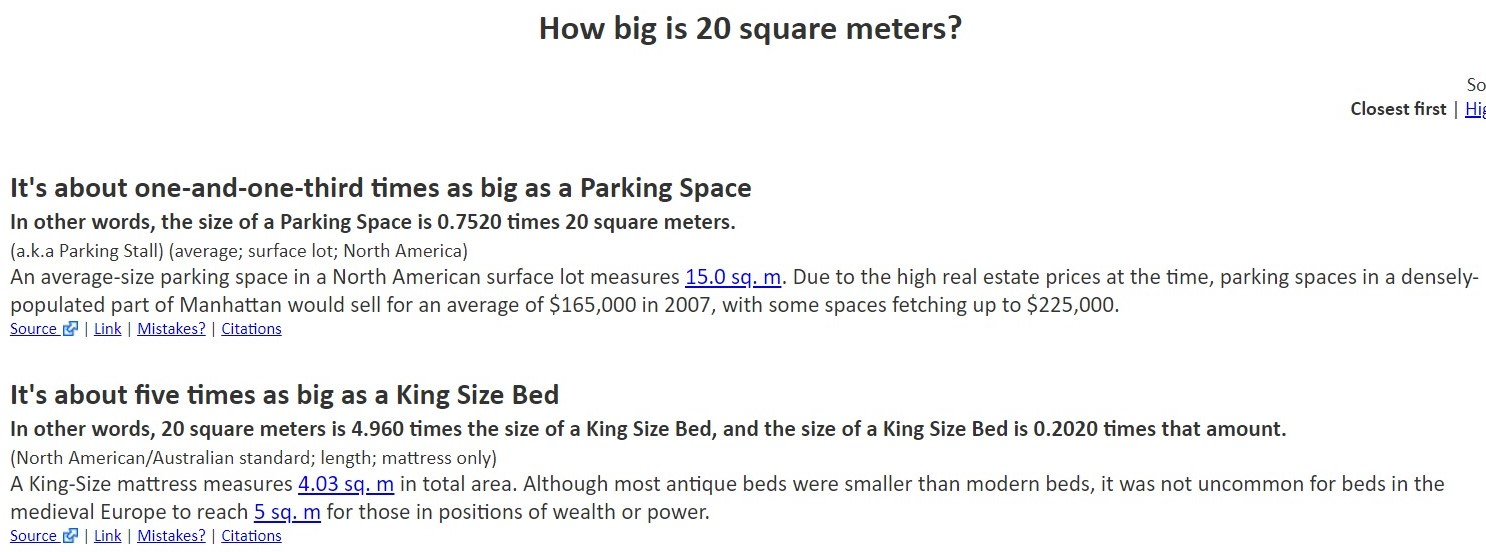

In [6]:
usData = usData[usData['area_ha'] > 0.002]
print(usData['year'].describe())

count    1.840184e+06
mean     2.001918e+03
std      6.877836e+00
min      1.986000e+03
25%      1.996000e+03
50%      2.002000e+03
75%      2.008000e+03
max      2.013000e+03
Name: year, dtype: float64


In [7]:
usData.head(10)

,latitude,longitude,year,mon,day,daynum,area_ha,cause_original,cause1,cause2,stateprov
0,40.036944,-121.005833,2005,2,2,33,0.040469,9,2,8,CA
1,38.933056,-120.404444,2004,5,12,133,0.101171,1,1,1,CA
2,38.984167,-120.735556,2004,5,31,152,0.040469,5,2,5,CA
3,38.559167,-119.913333,2004,6,28,180,0.040469,1,1,1,CA
4,38.559167,-119.933056,2004,6,28,180,0.040469,1,1,1,CA
5,38.635278,-120.103611,2004,6,30,182,0.040469,1,1,1,CA
6,38.688333,-120.153333,2004,7,1,183,0.040469,1,1,1,CA
7,40.968056,-122.433889,2005,3,8,67,0.323749,5,2,5,CA
8,41.233611,-122.283333,2005,3,15,74,0.404686,5,2,5,CA
9,38.548333,-120.149167,2004,7,1,183,0.040469,1,1,1,CA


In [21]:
def geography(dataset):
    
    #Create points from lat and long
    geometry = [Point(xy) for xy in zip(dataset['longitude'], dataset['latitude'])]
    
    #Specify Co-ordinate reference system, Create geodataframe
    geoData = gpd.GeoDataFrame(dataset, crs = 'epsg:4326', geometry = geometry)
    return geoData

In [22]:
geoUSData = geography(usData)

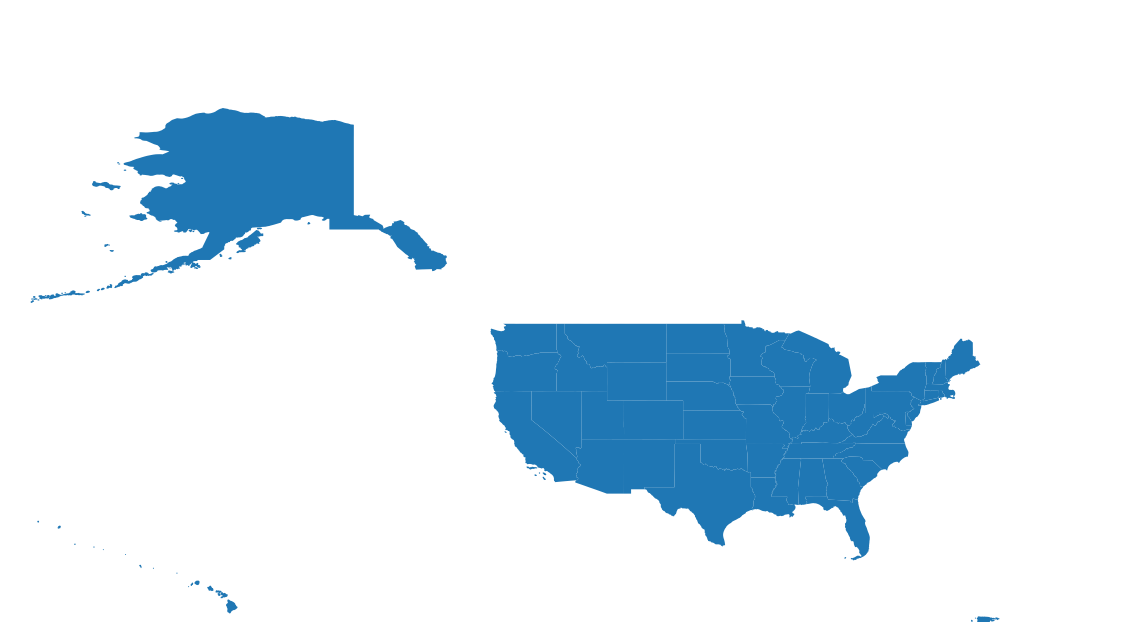

In [9]:
usMap = gpd.read_file("tl_2017_us_state.shp")
fig, ax = pyplt.subplots(figsize = (20, 20))
usMap.plot(ax = ax);
xlim = ([-182, -50])
ylim = ([18, 82])
ax.set_xlim(xlim);
ax.set_ylim(ylim);
ax.set_axis_off();

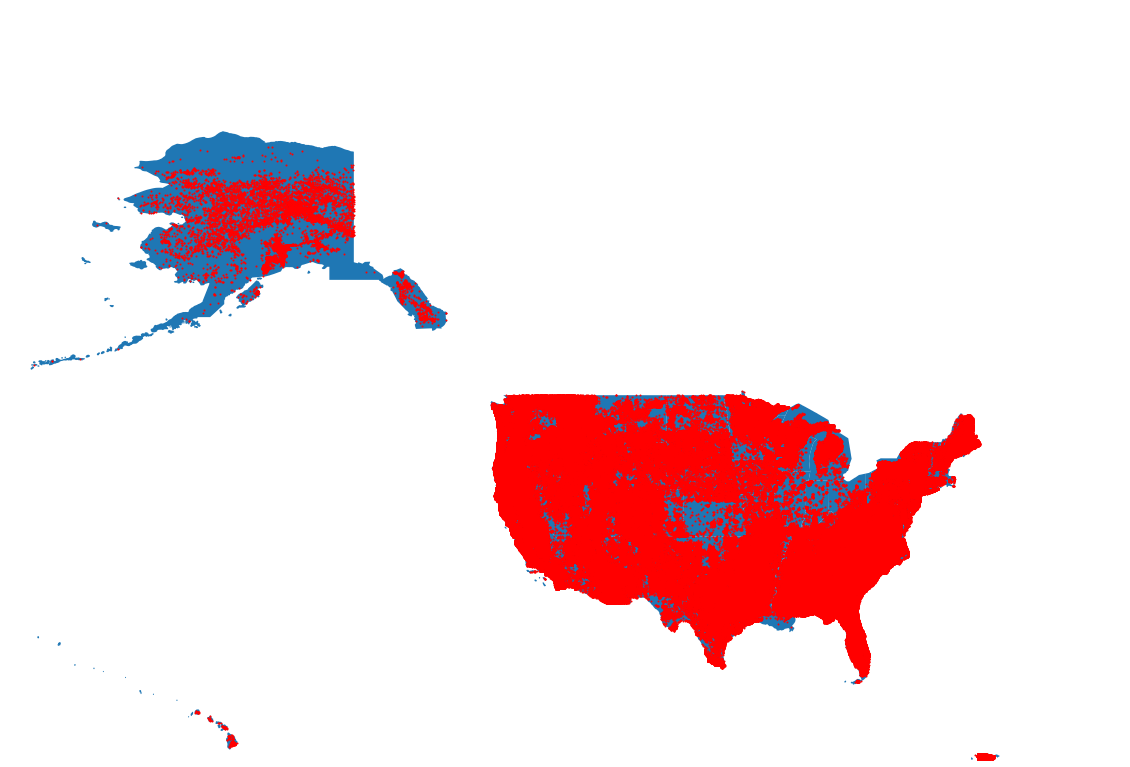

In [11]:
fig, ax = pyplt.subplots(figsize = (20, 20))
usMap.plot(ax = ax);
xlim = ([-182, -50])
ylim = ([18, 82])
ax.set_xlim(xlim);
ax.set_ylim(ylim);
ax.set_axis_off();

geoUSData.plot(ax = ax, markersize = 1, color = "red", marker = "o");

### Takeaways
***
This is a huge amount of data to go through, and harder for us to pinpoint specific instances of fires we want to highlight. Hence, we will drill down to fires within the states of California, Oregon and Washington; the west coast.

## West coast analysis

In [10]:
# Filter data down to only West Coast wildfires
westCoastData = usData[usData['stateprov'].isin(['CA', 'WA', 'OR'])]
print(westCoastData['year'].describe())

count    296770.000000
mean       2000.407069
std           7.520974
min        1986.000000
25%        1994.000000
50%        2001.000000
75%        2007.000000
max        2013.000000
Name: year, dtype: float64


In [19]:
geoWCData = geography(westCoastData)

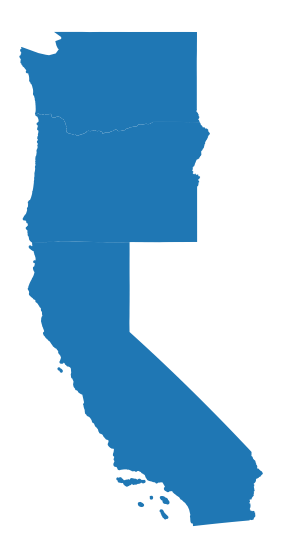

In [12]:
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap = usMap[usMap['NAME'].isin(['California', 'Oregon', 'Washington'])]
westCoastMap.plot(ax = ax);
ax.set_axis_off();

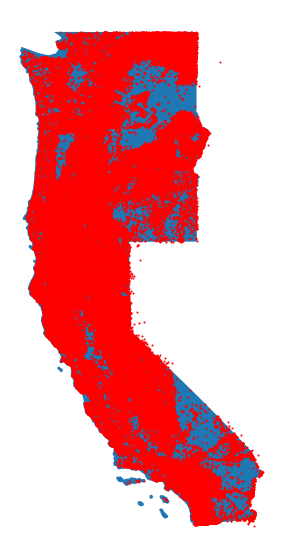

In [20]:
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoWCData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

# Unpreventable Fires:
***

### 1) Lightning started fires 1986-2013

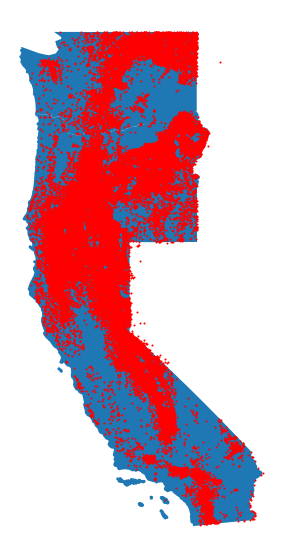

In [23]:
#Lightning started fires
lightningData = westCoastData[westCoastData['cause1'] == 1]
geoLightningData = geography(lightningData)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoLightningData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

### 2) Lightning fires in 2013

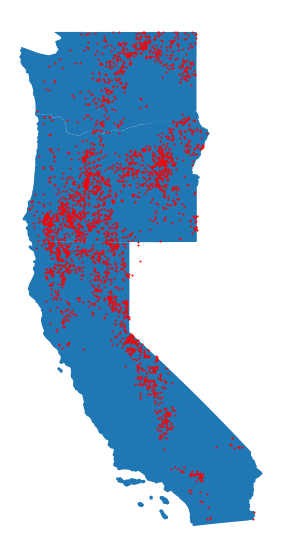

In [24]:
lightning2013Data = lightningData[lightningData['year'] == 2013]
geoLightning2013Data = geography(lightning2013Data)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoLightning2013Data.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

### Population check

Let's plot the counties on west coast with a population greater than 10,000. This gives us an idea of how close/damaging a fire can get near a community.

Source- https://hub.arcgis.com/datasets/esri::usa-major-cities

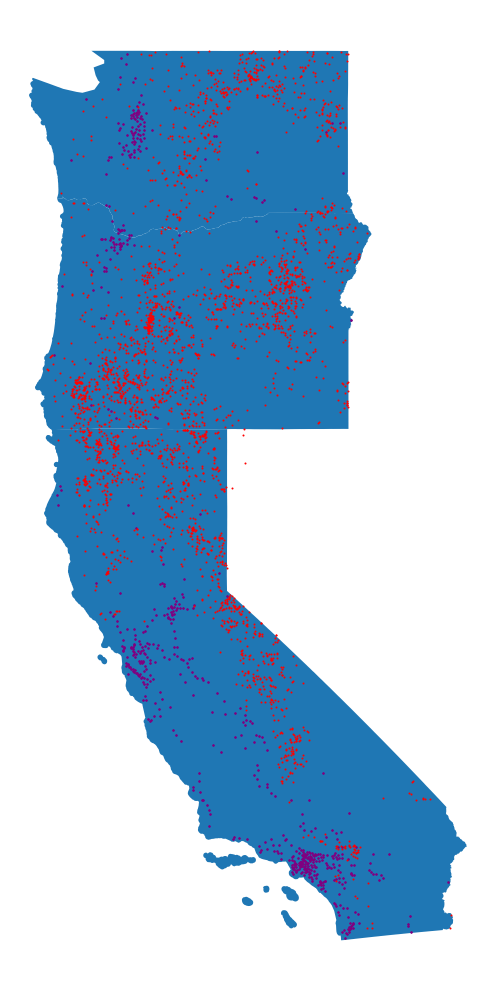

In [16]:
populationMap = gpd.read_file("0c5a2fa1-3463-4fc7-99e5-e206023a7e682020313-1-nmlntc.mln9c.shp")
populationMap = populationMap[populationMap['ST'].isin(['CA', 'WA', 'OR'])]
fig, ax = pyplt.subplots(figsize = (18, 18))
westCoastMap.plot(ax = ax);
populationMap.plot(ax = ax, markersize = 2, color = "purple", marker = "X", linewidth = 1);
geoLightning2013Data.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

### Taking a look at the number of deliberate fires, part of a prescribed burn

In [21]:
westCoastData.head()

,latitude,longitude,year,mon,day,daynum,area_ha,cause_original,cause1,cause2,stateprov,geometry
0,40.036944,-121.005833,2005,2,2,33,0.040469,9,2,8,CA,POINT (-121.00583 40.03694)
1,38.933056,-120.404444,2004,5,12,133,0.101171,1,1,1,CA,POINT (-120.40444 38.93306)
2,38.984167,-120.735556,2004,5,31,152,0.040469,5,2,5,CA,POINT (-120.73556 38.98417)
3,38.559167,-119.913333,2004,6,28,180,0.040469,1,1,1,CA,POINT (-119.91333 38.55917)
4,38.559167,-119.933056,2004,6,28,180,0.040469,1,1,1,CA,POINT (-119.93306 38.55917)


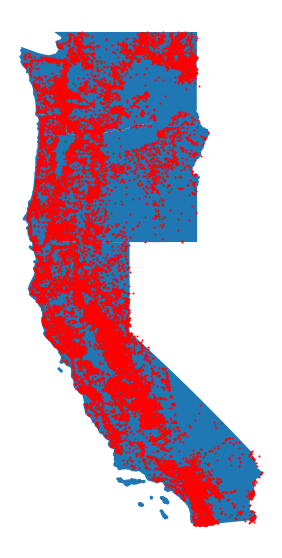

In [25]:
#Deliberate started fires
deliberateData = westCoastData[(westCoastData['cause1'] == 2) & (westCoastData['cause2'] == 5)]
geoDeliberateData = geography(deliberateData)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoDeliberateData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

# Preventable Fires
***

### 1) Campfires

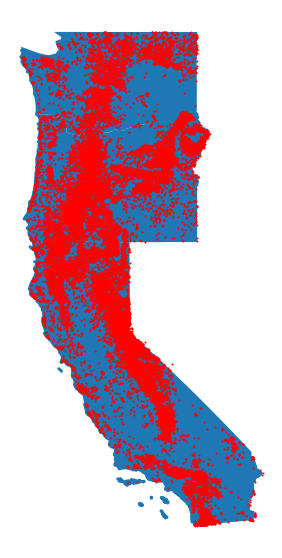

In [26]:
# Campfire started fires 
campfireData = westCoastData[(westCoastData['cause1'] == 2) & (westCoastData['cause2'] == 4)]
geoCampfireData = geography(campfireData)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoCampfireData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

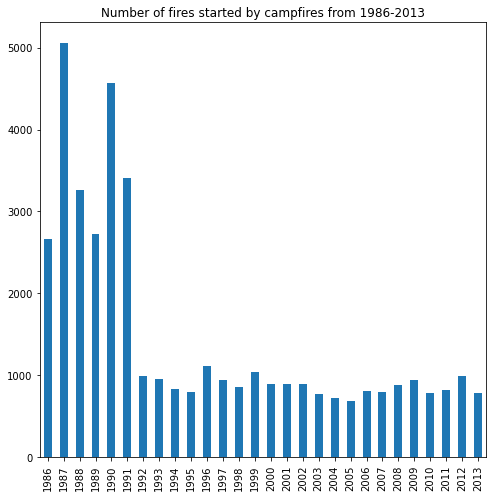

In [28]:
campfireData['year'].value_counts().sort_index().plot(figsize=(8,8), kind='bar', title='Number of fires started by campfires from 1986-2013');

### Campfire takeaways
***
Over the years, campfire related fires have been on the decrease. In Sacramento, in 2018, the camp fire in Butte County which started the morning of November 8, burned a total of 153,336 acres, destroying 18,804 structures and resulting in 85 civilian fatalities and several firefighter injures. The camp fire is the deadliest and most destructive fire in California history.

It is important to educate others, which the California Department of Forestry and Fire Protection did by releasing a statement: During 2018 there were more than 7,571 wildfires that burned over 1.8 million acres within the state of California.

### 2) Smoking

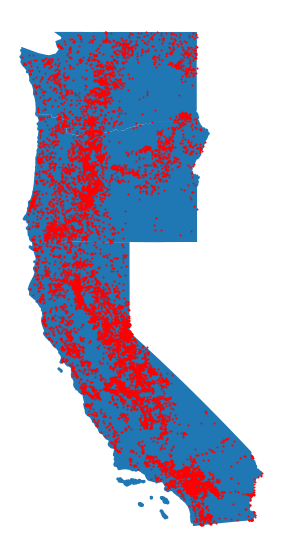

In [29]:
# Wildfires started by smoking
smokingData = westCoastData[(westCoastData['cause1'] == 2) & (westCoastData['cause2'] == 3)]
geoSmokingData = geography(smokingData)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoSmokingData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

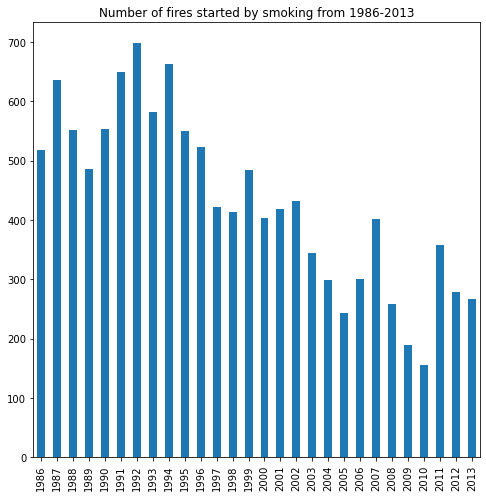

In [30]:
smokingData['year'].value_counts().sort_index().plot(figsize=(8, 8), kind='bar', title='Number of fires started by smoking from 1986-2013');

### Smoking takeaways
***
Similarly, over the years, smoking related fires have been on the decrease. [According to the United States Forest Service Research & Development](https://www.fs.fed.us/research/highlights/highlights_display.php?in_high_id=733),the number of wildfires caused by smoking has declined by 90 percent in national forests since 1980. Still, little is known about why this is the case, when most other causes have not declined so precipitously. Collaborative research between the Forest Service scientists and the National Institute of Standards and Technology indicates that one-tenth of the decline is attributable to the reduction in adult smoking rates, one-fourth to the emergence of less fire prone "fire-safe" cigarettes, while nearly half is likely due to improved wildfire investigation methods.


### 3) Juveniles

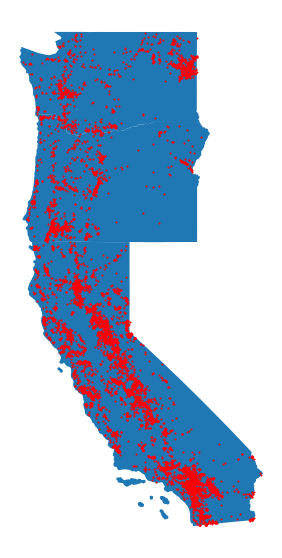

In [32]:
# Wildfires started by Juveniles
juvenileData = westCoastData[(westCoastData['cause1'] == 2) & (westCoastData['cause2'] == 7)]
geoJuvenileData = geography(juvenileData)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoJuvenileData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

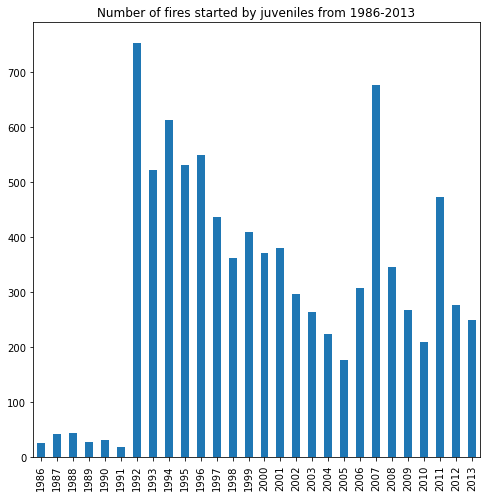

In [33]:
juvenileData['year'].value_counts().sort_index().plot(figsize=(8, 8), kind='bar', title='Number of fires started by juveniles from 1986-2013');

### Juvenile started fires takeaway
***
[According to the Washington Post](https://www.washingtonpost.com/news/post-nation/wp/2016/12/07/two-juveniles-charged-with-arson-in-deadly-east-tennessee-wildfires/), in 2016, two juveniles were charged with aggravated arson in connection with wildfires that ravaged two East Tennesse resort towns, killing 14 people and leaving nearly 150 others injured and damaging or destroying more than 2,400 properties. The fire roared throughout the Great Smoky Mountains National Park and spread into Gatlinburg and Pigeon Forge.

Wildfires started by someone under the age of majority could lead to severe consequences that may even lead to repayment in the millions for the damages wrought. A teen facing the charges of starting a wildfire may face state or federal penalties if a conviction does occur, and often the judge will determine the youth will face the trial as an adult.

### 4) Incendiary

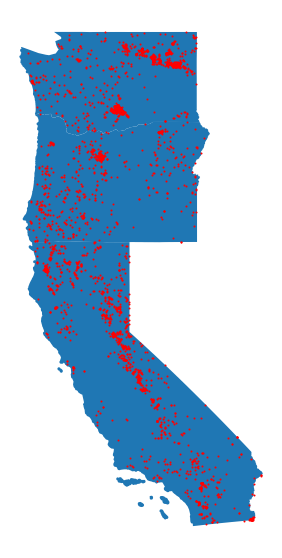

In [34]:
# Wildfires started by Incendiaries 
incendiaryData = westCoastData[(westCoastData['cause1'] == 2) & (westCoastData['cause2'] == 9)]
geoIncendiaryData = geography(incendiaryData)
fig, ax = pyplt.subplots(figsize = (10, 10))
westCoastMap.plot(ax = ax);
geoIncendiaryData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

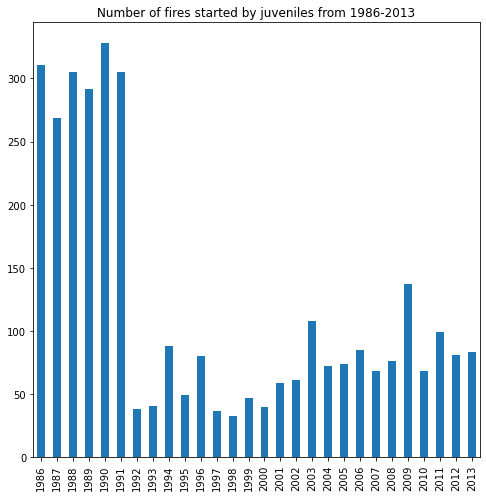

In [35]:
incendiaryData['year'].value_counts().sort_index().plot(figsize=(8, 8), kind='bar', title='Number of fires started by juveniles from 1986-2013');

### Incendiary fires takeaway
***
An incendiary fire is a fire that has been deliberately ignited under circumstances in which the person knows the fire should not be ignited. Incendiary isn't always arson, arson has intent to cause bodily harm/property damage. 

[According to the United States Department of Agriculture Forest Service](https://www.srs.fs.fed.us/pubs/gtr/gtr_srs171.pdf), The second most common wildfire cause in recent years on Department of the Interior lands is incendiary, comprising 15.5 percent of reported ignitions. Some recent efforts at understanding human-caused wildfires have focused on incendiary wildfires and the effect of law enforcement, which can be considered a prevention activity (particularly when done by the land management agency). 

## Comparison between two classes of Wildfires, Preventable and Unpreventable

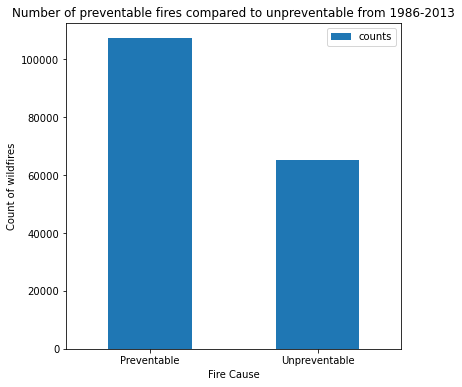

In [38]:
# Set up the x axis for the bar chart with the labels 
classes = ['Preventable', 'Unpreventable']

# Retrieve the counts of unpreventable and preventable fires
preventableFireCount = len(lightningData.index) + len(deliberateData.index)

unpreventableFireCount = len(campfireData.index) + len(smokingData.index) + len(juvenileData.index) + len(incendiaryData.index)

counts = [preventableFireCount, unpreventableFireCount]

df = pd.DataFrame({'class':classes, 'counts':counts})
ax = df.plot.bar(x='class', y='counts', rot=0, figsize=(6, 6), title="Number of preventable fires compared to unpreventable from 1986-2013");
ax.set_xlabel("Fire Cause");
ax.set_ylabel("Count of wildfires");

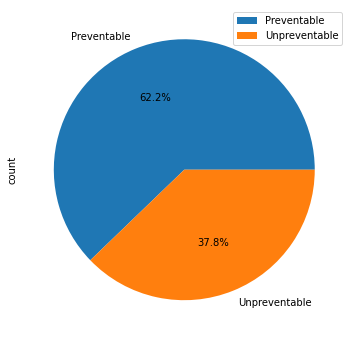

In [41]:
df = pd.DataFrame({'count': counts}, index=classes)
plot = df.plot.pie(y='count', figsize=(6, 6), autopct='%1.1f%%')

## Conclusion
***
### Wildfires are often preventable, because many originate from human error. It is important to understand that, unlike any other natural disasters, most wildfires are caused by people, and can be prevented by people, too. 62.2% of the wildfires from 1986-2013 were preventable, meaning they were caused by either campfires, smoking, juveniles, or incendiaries.

### Because of the increase in preventable fires, now more than ever with the looming threat of climate change, we need to help prevent them. The U.S. Forest Service launched an American campaign and advertising icon, Smokey the Bear. It is the longest-running public service announcement campaign in the United States. Smokey Bear was designed to educate the public about the dangers of unplanned human-caused wildfires. Smokey says, "Care Will Prevent 9 out of 10 Forest Fres", and 'Only YOU can Prevent Forest Fires". 

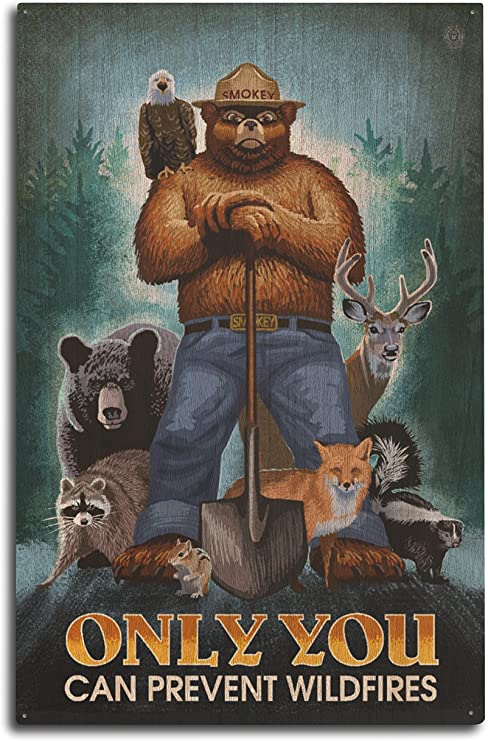